![image](https://raw.githubusercontent.com/IBM/watsonx-ai-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Use watsonx, and `mistralai/mistral-small-3-1-24b-instruct-2503` with support for tools to perform simple calculations

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.


## Notebook content

This notebook provides a detailed demonstration of the steps and code required to showcase support for Chat models, including the integration of tools using [LangGraph](https://langchain-ai.github.io/langgraph/) and watsonx.ai models.

Some familiarity with Python is helpful. This notebook uses Python 3.12.


## Learning goal

The purpose of this notebook is to demonstrate how to use Chat models, e.g. `mistralai/mistral-small-3-1-24b-instruct-2503` using the tools available in LangGraph. LangGraph is an Agent Orchestrator with which you can build graph applications that automatically execute sequences of actions and in which the LLM is the key decision maker that determines the next step.


## Table of Contents

This notebook contains the following parts:

- [Setup](#setup)
- [Foundation Models on watsonx](#models)
- [LangChain integration](#chatwatsonx)
- [Example](#example)
- [Summary](#summary)

<a id="setup"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pak for Data administrator and ask them for your account credentials

### Install and import the `datasets` and dependencies

In [1]:
%pip install -U "langgraph>0.2,<0.3" | tail -n 1
%pip install -U "langchain_ibm>=0.3,<0.4" | tail -n 1

#### Define credentials

Authenticate the watsonx.ai Runtime service on IBM Cloud Pak for Data. You need to provide the **admin's** `username` and the platform `url`.

In [2]:
username = "PASTE YOUR USERNAME HERE"
url = "PASTE THE PLATFORM URL HERE"

Use the **admin's** `api_key` to authenticate watsonx.ai Runtime services:

In [ ]:
import getpass
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=getpass.getpass("Enter your watsonx.ai API key and hit enter: "),
    url=url,
    instance_id="openshift",
    version="5.2",
)

Alternatively you can use the **admin's** `password`:

In [3]:
import getpass
from ibm_watsonx_ai import Credentials

if "credentials" not in locals() or not credentials.api_key:
    credentials = Credentials(
        username=username,
        password=getpass.getpass("Enter your watsonx.ai password and hit enter: "),
        url=url,
        instance_id="openshift",
        version="5.2",
    )

### Working with projects

First of all, you need to create a project that will be used for your work. If you do not have a project created already, follow the steps below:

- Open IBM Cloud Pak main page
- Click all projects
- Create an empty project
- Copy `project_id` from url and paste it below

**Action**: Assign project ID below

In [4]:
import os

try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Please enter your project_id (hit enter): ")

#### Create `APIClient` instance

In [5]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials, project_id=project_id)

<a id="models"></a>
## Set up a Foundation Model on `watsonx.ai`


#### Specify chat model

This notebook uses chat model `mistralai/mistral-small-3-1-24b-instruct-2503`, which has to be available on your Cloud Pak for Data environment for this notebook to run successfully.  
If this model is not available on your Cloud Pak for Data environment, you can specify any other available chat model.  
You can list available chat models by running the cell below.

In [6]:
if len(client.foundation_models.ChatModels):
    print(*client.foundation_models.ChatModels, sep="\n")
else:
    print(
        "Chat models are missing in this environment. Install chat models to proceed."
    )

ibm/granite-3-3-8b-instruct
meta-llama/llama-3-3-70b-instruct
mistralai/mistral-small-3-1-24b-instruct-2503


In [7]:
model_id = client.foundation_models.ChatModels.MISTRAL_SMALL_3_1_24B_INSTRUCT_2503

<a id="chatwatsonx"></a>
## LangChain integration

`ChatWatsonx` is a wrapper around watsonx.ai models that provides chat integration around the models.

### Initialize the `ChatWatsonx` class

In [8]:
from langchain_ibm import ChatWatsonx

if credentials.api_key:
    chat = ChatWatsonx(
        url=credentials.url,
        apikey=credentials.api_key,
        instance_id="openshift",
        model_id=str(model_id),
        project_id=project_id,
    )
else:
    chat = ChatWatsonx(
        url=credentials.url,
        username=credentials.username,
        password=credentials.password,
        instance_id="openshift",
        model_id=str(model_id),
        project_id=project_id,
    )

Next, define the assistant's tools to make a calculation.

In [9]:
from langchain_core.tools import tool


@tool
def add(a: float, b: float) -> float:
    """Add a and b."""
    return a + b


@tool
def subtract(a: float, b: float) -> float:
    """Subtract a and b."""
    return a - b


@tool
def multiply(a: float, b: float) -> float:
    """Multiply a and b."""
    return a * b


@tool
def divide(a: float, b: float) -> float:
    """Divide a and b."""
    return a / b


tools = [add, subtract, multiply, divide]

Define the graph.

In [10]:
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(chat, tools=tools)

Visualize the graph you just created.

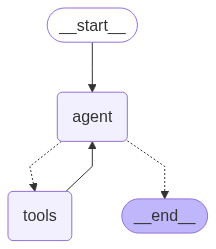

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Add a helpful function to print messages from the model.

In [12]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

<a id="example"></a>
## Example

Run the app with an input that needs a tool call.

In [13]:
inputs = {
    "messages": [("user", "What is the total sum of the numbers 11, 13, and 20?")]
}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the total sum of the numbers 11, 13, and 20?
================================== Ai Message ==================================
Tool Calls:
  add (TNVJyNOBB)
 Call ID: TNVJyNOBB
  Args:
    a: 11
    b: 13
  add (ygV7Pjw6w)
 Call ID: ygV7Pjw6w
  Args:
    a: 24
    b: 20
================================= Tool Message =================================
Name: add

44.0
================================== Ai Message ==================================

The total sum of the numbers 11, 13, and 20 is 44.


In [14]:
inputs = {"messages": [("user", "What is the result when 81 is subtracted from 100?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the result when 81 is subtracted from 100?
================================== Ai Message ==================================
Tool Calls:
  subtract (f1BIGANVo)
 Call ID: f1BIGANVo
  Args:
    a: 100
    b: 81
================================= Tool Message =================================
Name: subtract

19.0
================================== Ai Message ==================================

The result when 81 is subtracted from 100 is 19.


In [15]:
inputs = {"messages": [("user", "Calculate the result of multiplying 10 by 12.")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Calculate the result of multiplying 10 by 12.
================================== Ai Message ==================================
Tool Calls:
  multiply (IuhEHDnNI)
 Call ID: IuhEHDnNI
  Args:
    a: 10
    b: 12
================================= Tool Message =================================
Name: multiply

120.0
================================== Ai Message ==================================

The result of multiplying 10 by 12 is 120.0


In [16]:
inputs = {"messages": [("user", "Determine the result of dividing 2 by 3.")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Determine the result of dividing 2 by 3.
================================== Ai Message ==================================
Tool Calls:
  divide (Px8rH849i)
 Call ID: Px8rH849i
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: divide

0.6666666666666666
================================== Ai Message ==================================

The result of dividing 2 by 3 is approximately 0.6667.


In [17]:
inputs = {
    "messages": [
        (
            "user",
            "What is the result when the sum of 2 and 3 is multiplied by 6 and then divided by 10?",
        )
    ]
}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the result when the sum of 2 and 3 is multiplied by 6 and then divided by 10?
================================== Ai Message ==================================

First, we need to calculate 2 + 3:
2 + 3 = 5

Next, we multiply the result by 6:
5 * 6 = 30

Finally, we divide by 10:
30 / 10 = 3

So, the result is 3.


<a id="summary"></a>
## Summary and next steps

You successfully completed this notebook!

You learned how to build a simple graph using LangGraph and `ChatWatsonx`.

Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Mateusz Szewczyk**, Software Engineer at watsonx.ai.

Copyright © 2024-2025 IBM. This notebook and its source code are released under the terms of the MIT License.